In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")

device = 'cpu'
%load_ext autoreload
%autoreload 2

mse = torch.nn.MSELoss()

desired_range = [735,865]
desired_channels = 50
cropsize=[500,640]

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
kernel = torch.load('../final_kernel.pt',map_location=device).requires_grad_(False)

undisp_cube = torch.tensor(np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_analysis_exptime_6250_us/gtcube.npy')).to(device)
mask = torch.tensor(np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_analysis_exptime_6250_us/mask.npy')).to(device)


nc = undisp_cube.shape[1]

datadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_data_exptime_6250_us/' 
    
orig_spectras = np.load(datadir+'spectra.npy') 
initial_bins = np.linspace(634.69, 1124.5, orig_spectras.shape[0])

spectras, final_bins = hlp.fix_spectra(orig_spectras, initial_bins, desired_range = desired_range)
spectras[(final_bins<745) | (final_bins>855)] = 0

spectras = hlp.downsample_signal(spectras, desired_channels, final_bins * 1e-9, desired_range = desired_range, interp_axis = 0, interp_type='average') #interpolate to 750-850nm
spectras = torch.tensor(spectras).float().to(device)
cutoff = [450,950]
spectras = spectras[:,cutoff[0]:cutoff[1]]

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras, crop=cropsize, random_shifts=False)

In [26]:
grating_cube = torch.tensor(np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_mask_analysis_exptime_1000_us/grating_cube.npy')).to(device)

In [27]:
grating_cube.shape, undisp_cube.shape

(torch.Size([1, 40, 500, 2448]), torch.Size([1, 50, 500, 2448]))

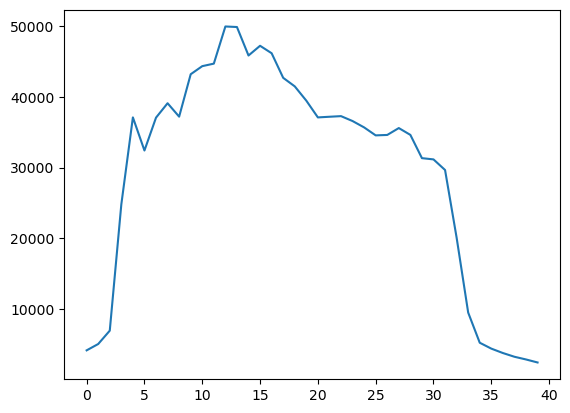

In [28]:
plt.plot(torch.mean(grating_cube,dim=(0,2,3)))

## Test a model I trained on all the data (using train_model.py)

In [29]:
model = FourierDenoiser(kernel=kernel,CoordGate=False, channels=desired_channels, cropsize=cropsize).to(device)
# model.load_state_dict(torch.load('fourier_denoiser_b')); #trained on all data.
model.load_state_dict(torch.load('../syn')); #trained on all data.
model.load_state_dict(torch.load('../FTS_unet_rand_shifts')); #trained on all data.

model.eval();

In [30]:
# %%timeit

indexes = [20,30]
(x,y) = dataset[indexes]
y_pred = model(x)

mse(y_pred,y)

tensor(0.0011, grad_fn=<MseLossBackward0>)

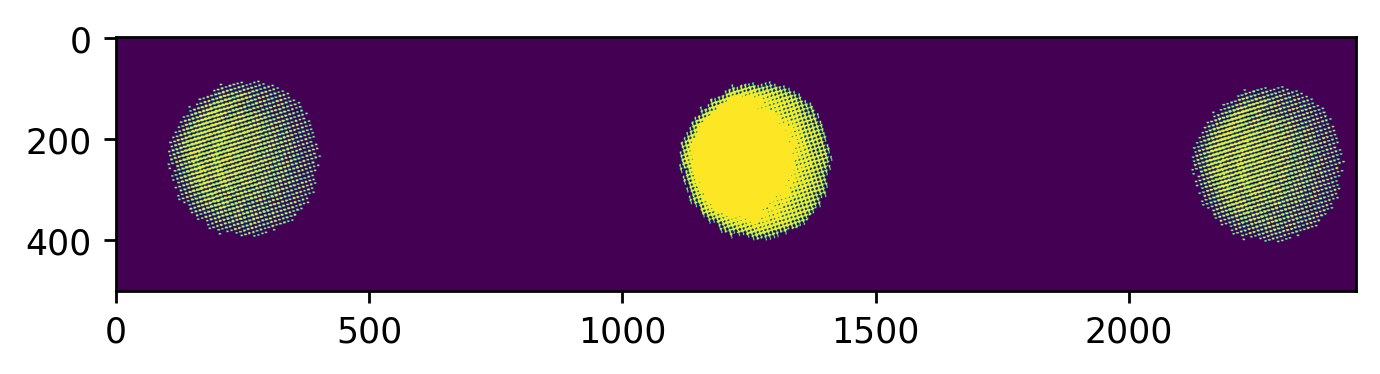

In [31]:
plt.figure(dpi=250)
plt.imshow(mask[0,-1].cpu())

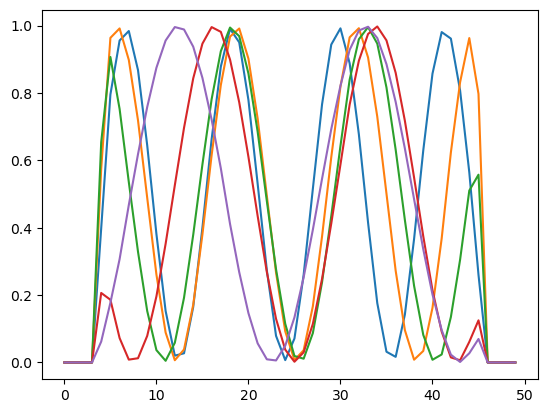

In [32]:
for i in range(0,150,30):
    plt.plot(spectras[:,i])


In [33]:
kernel.mean((0,2,3))

tensor([3.0892e-07, 2.4309e-07, 4.0254e-07, 2.9367e-07, 2.4893e-07, 2.4997e-07,
        2.6483e-07, 2.8031e-07, 2.8673e-07, 2.9139e-07, 2.8668e-07, 2.8608e-07,
        2.9271e-07, 2.9220e-07, 2.8477e-07, 2.7255e-07, 2.7140e-07, 2.7374e-07,
        2.8135e-07, 2.9174e-07, 3.0297e-07, 3.0767e-07, 2.9973e-07, 2.9397e-07,
        2.9463e-07, 2.9775e-07, 3.0014e-07, 3.0762e-07, 3.2063e-07, 3.2490e-07,
        3.1481e-07, 3.0304e-07, 3.0570e-07, 3.1650e-07, 3.1829e-07, 3.1134e-07,
        3.0757e-07, 3.0943e-07, 2.9883e-07, 2.8746e-07, 2.8843e-07, 3.2632e-07,
        4.4005e-07, 3.2424e-07, 2.6605e-07, 2.5077e-07, 2.4165e-07, 3.0349e-07,
        3.0627e-07, 3.0240e-07])

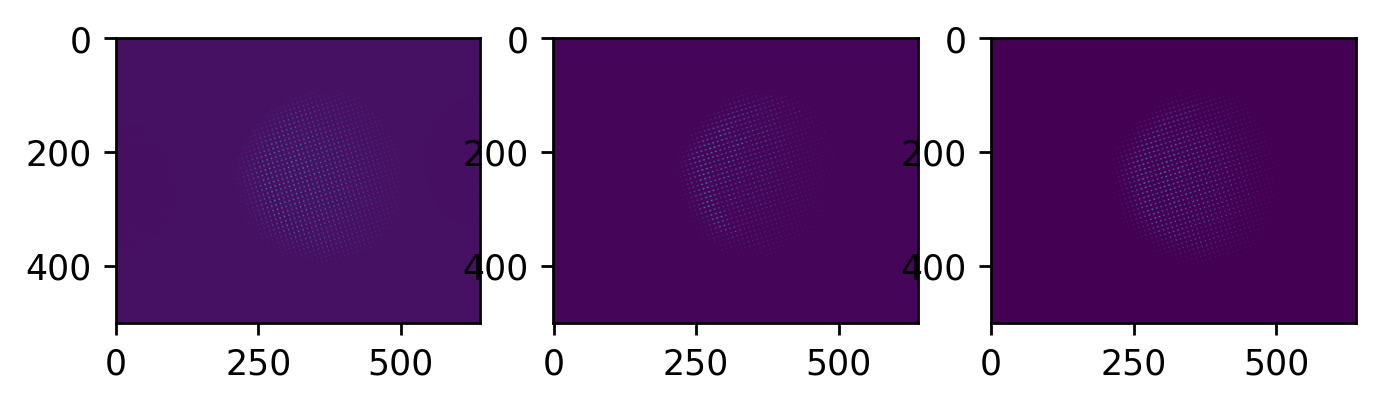

In [34]:
wl=20

bla = model.data_term(x, kernel,mask)
bla2 = model.crop(bla,cropsize)
bla3 = model.unet(bla2)
fig,ax = plt.subplots(1,3,dpi=250)
ax[0].imshow(bla2[0,wl].cpu().detach())
ax[1].imshow(bla3[0,wl].cpu().detach())
ax[2].imshow(y[0,wl].cpu().detach())

Text(0.5, 1.0, 'Original')

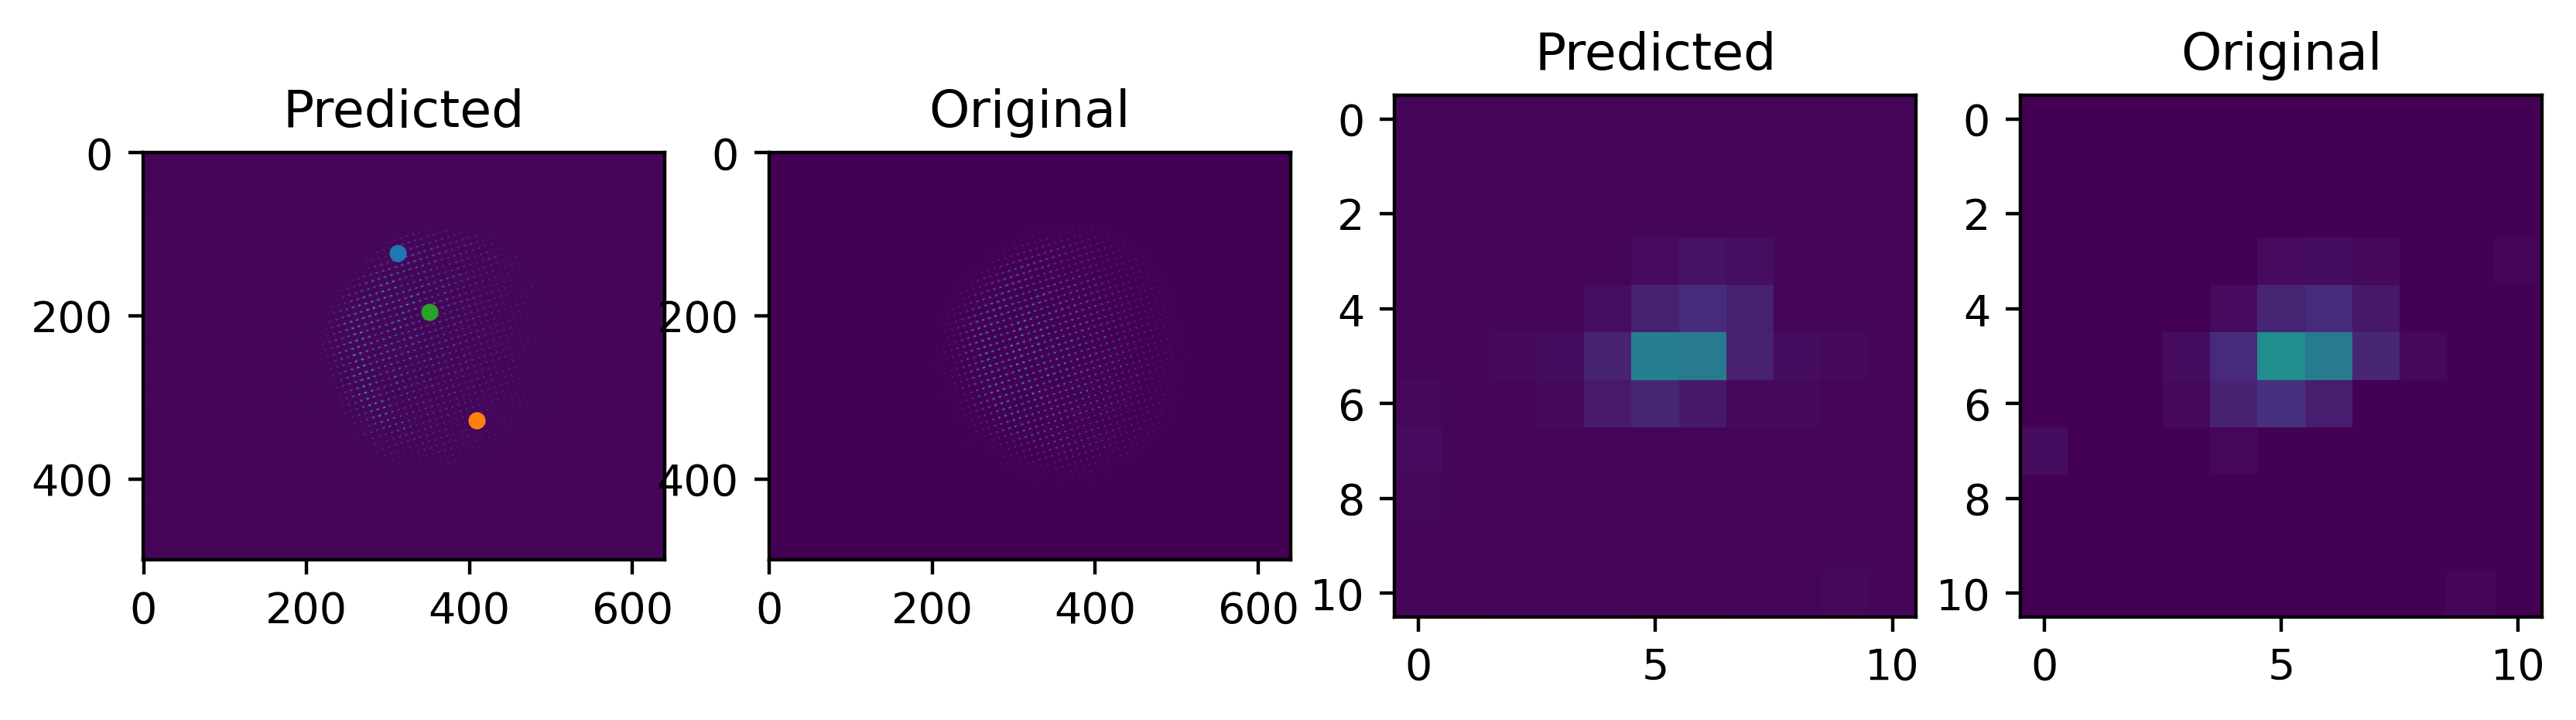

In [35]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,20].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,20].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [123,312]
boxsize = 5

coords2 = [328,409]
coords3 = [195,351]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')
ax[0].plot(coords3[1],coords3[0],'.')

coords = coords3

wl = 20

ax[2].imshow(y_pred[0,wl,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,wl].cpu().detach().numpy().max(),vmin = y_pred[0,wl].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,wl,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,wl].cpu().detach().numpy().max(),vmin = y[0,wl].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

Text(0.5, 1.0, 'Original')

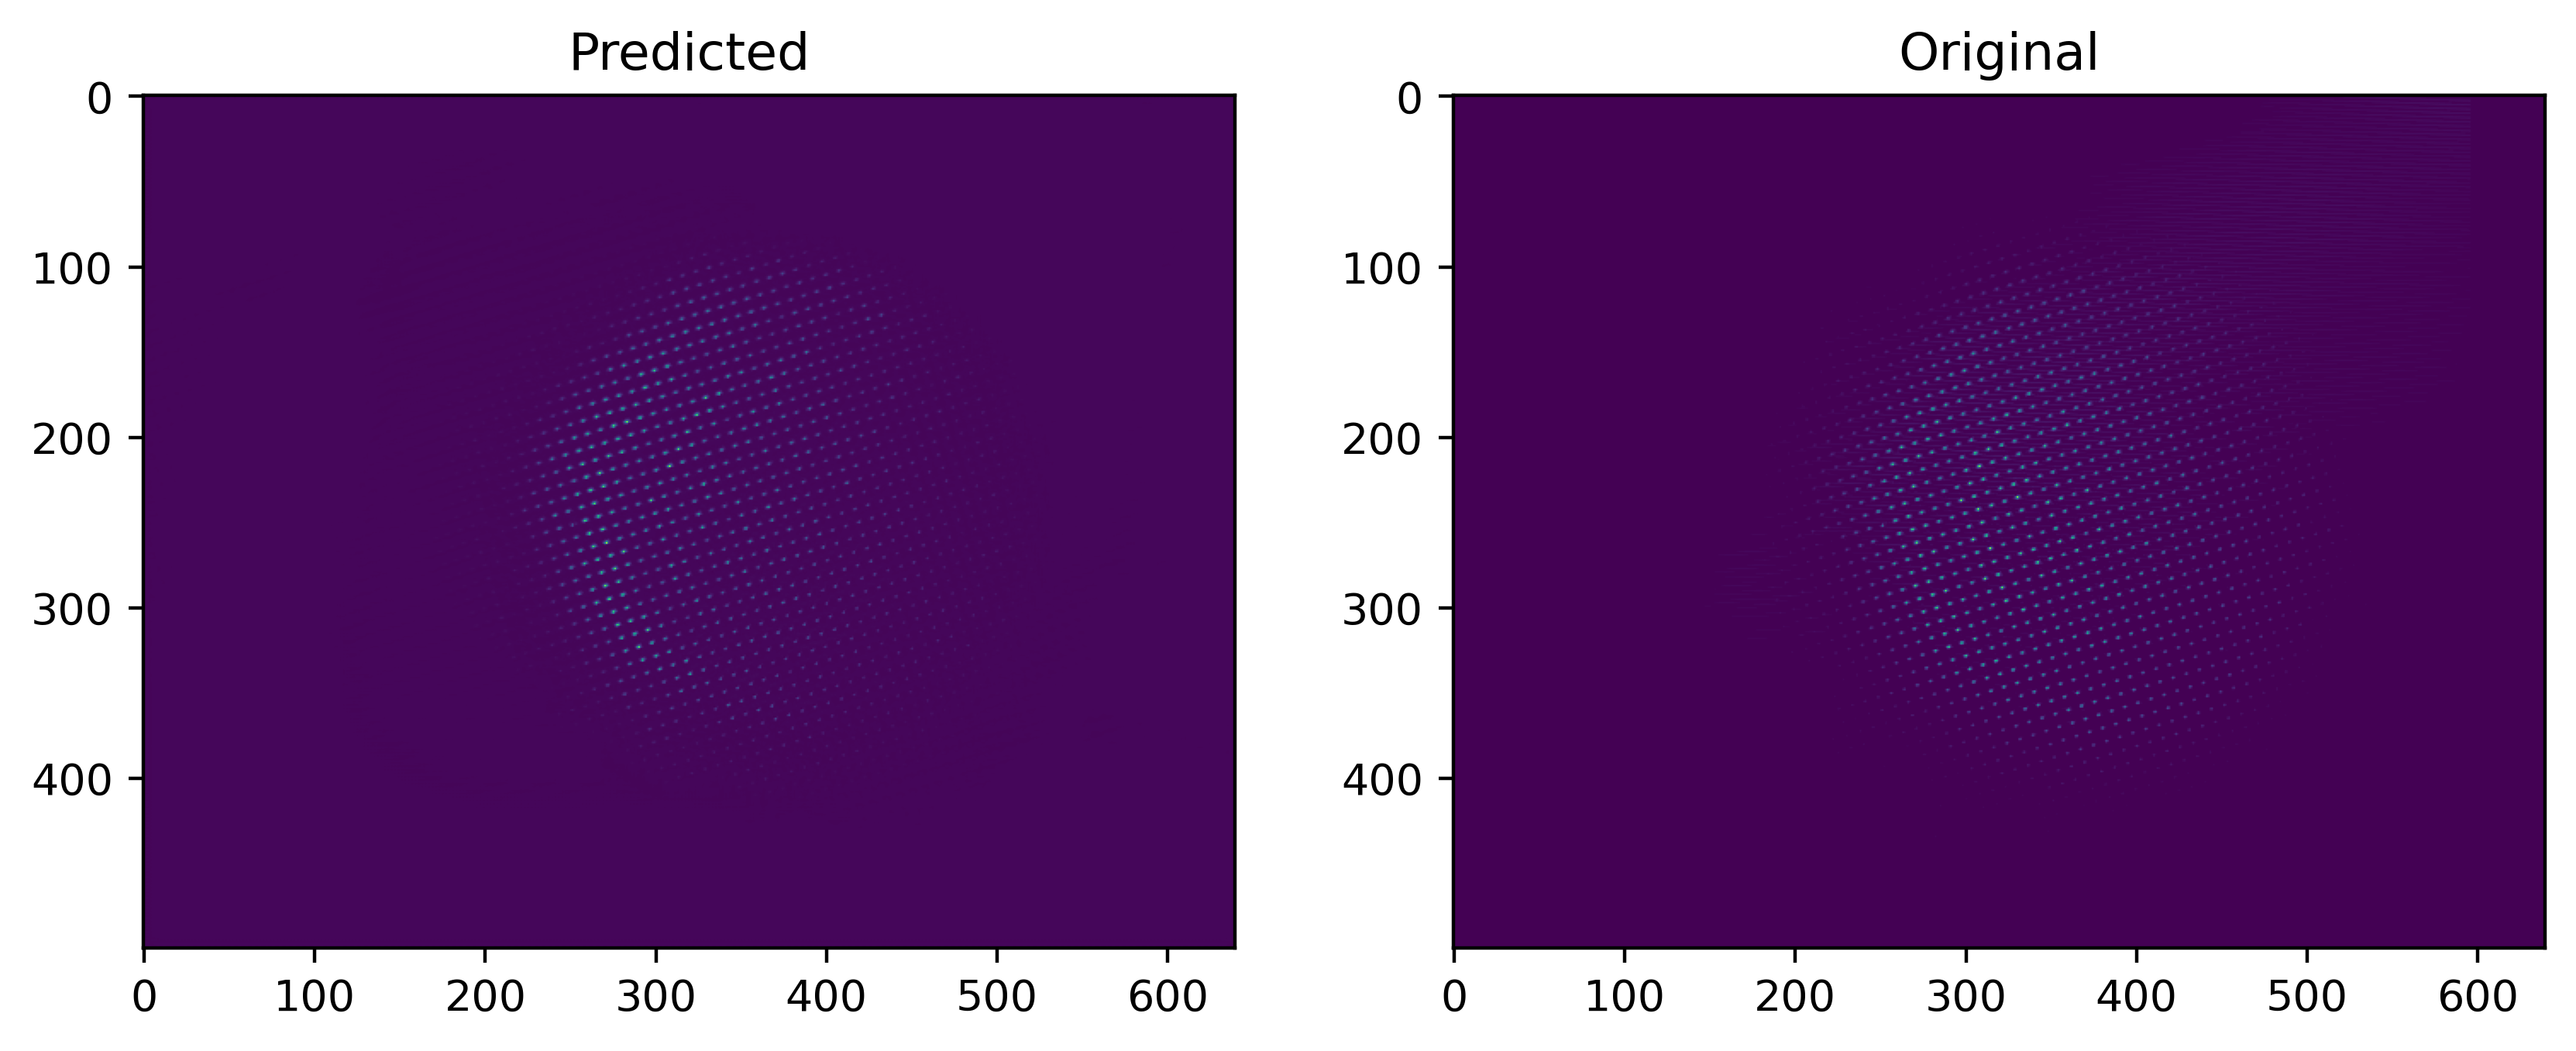

In [36]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,20].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,25].cpu().detach().numpy())    ; ax[1].set_title('Original')

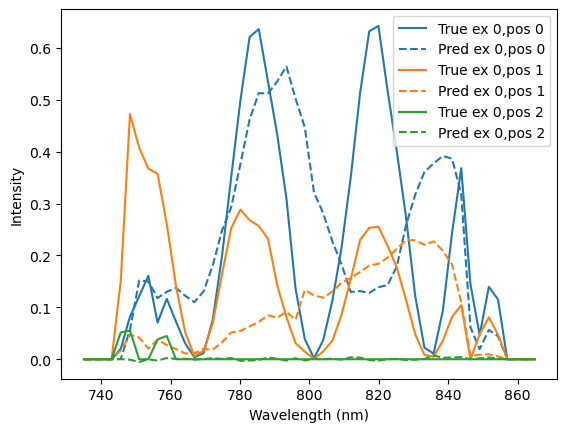

In [37]:
wls = np.linspace(desired_range[0],desired_range[1],desired_channels)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2, coords3]

for i in range(3):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

In [38]:
x_syn, y_syn = x.clone(), y.clone()

In [39]:
positions = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_data_exptime_6250_us/positions.npy')[cutoff[0]:cutoff[1]]

ftsdataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras,positions=positions,dir = '20230906_1grating_mask_data_exptime_6250_us',  crop=cropsize, random_shifts=False)




In [40]:
indexes = [20,25]
(x,y) = ftsdataset[indexes]
y_pred = model(x)

mse(y_pred,y)

tensor(0.0002, grad_fn=<MseLossBackward0>)

In [41]:
x.max(),x.mean(),x.min(), x_syn.max(),x_syn.mean(),x_syn.min(), y.max(),y.mean(),y.min()

(tensor(7.7340),
 tensor(0.0226),
 tensor(0.0002),
 tensor(6.3532),
 tensor(0.0215),
 tensor(0.),
 tensor(3.3414),
 tensor(0.0048),
 tensor(0.))

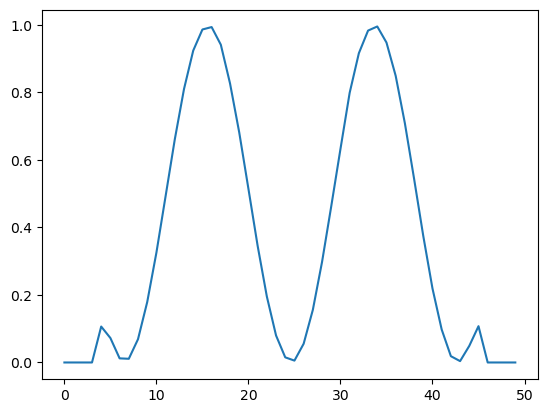

In [42]:
plt.plot(spectras[:,100])

Text(0.5, 1.0, 'Original')

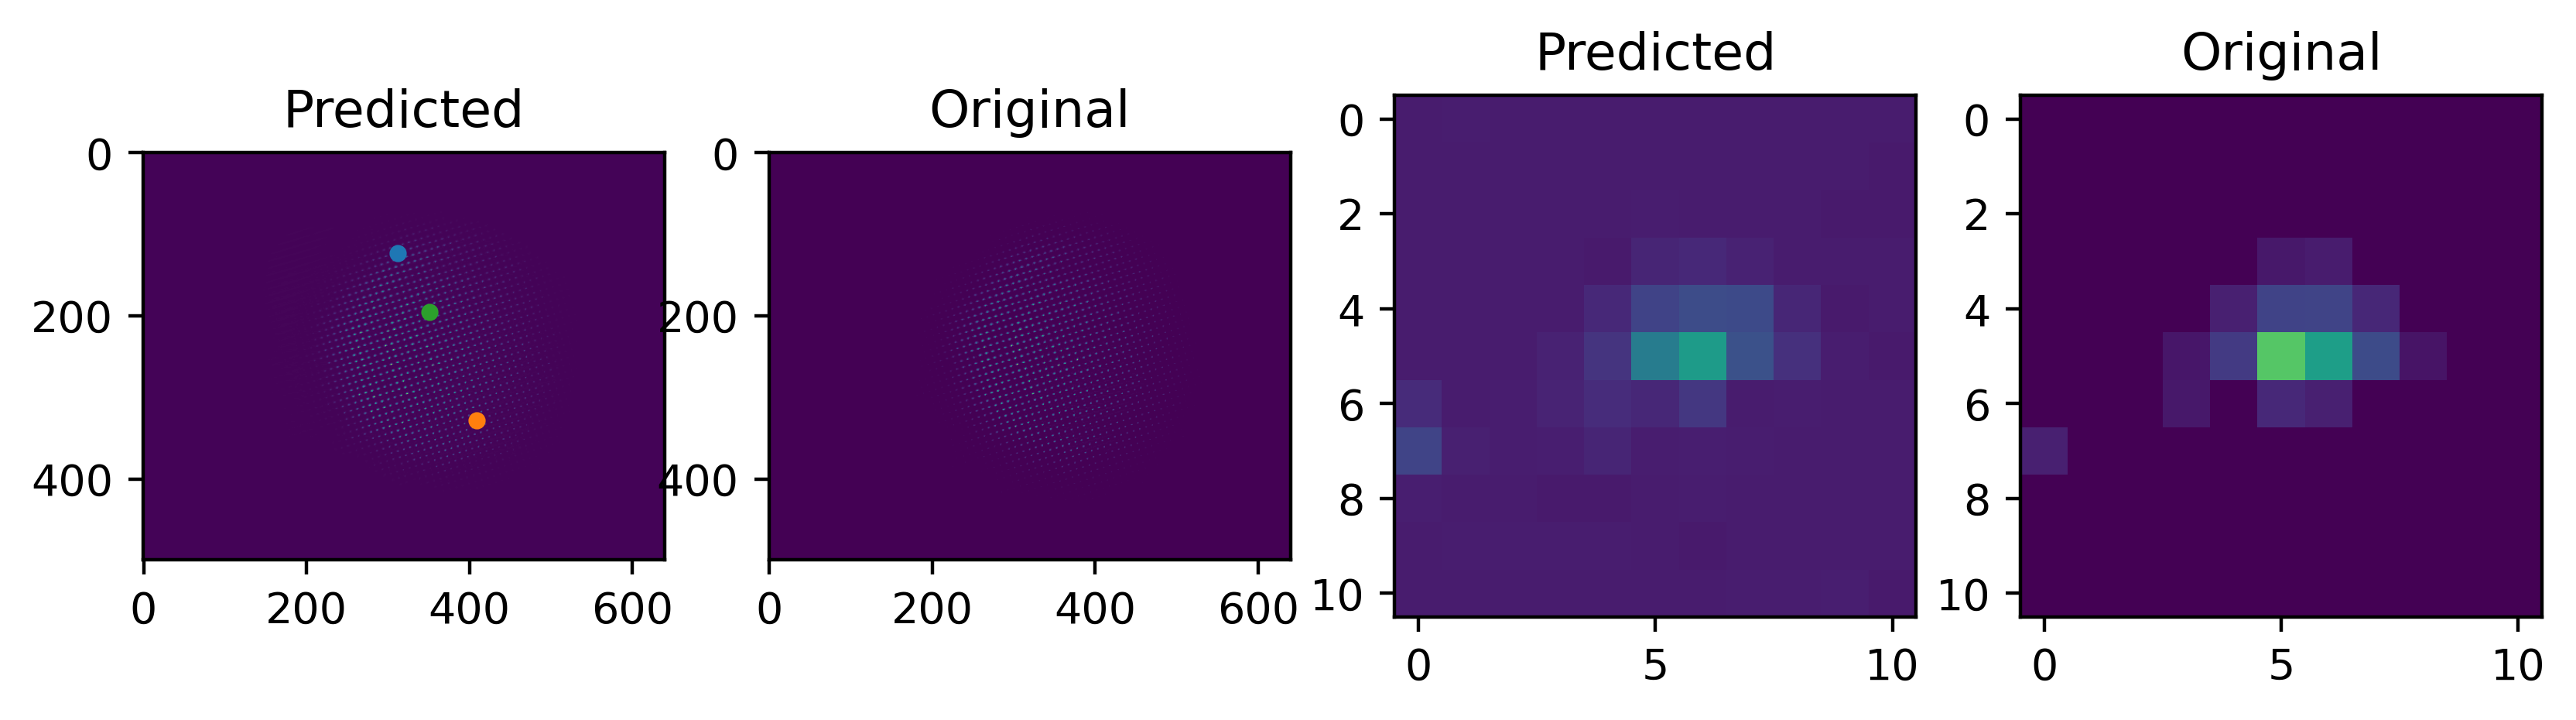

In [43]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,wl].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,wl].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [123,312]
boxsize = 5

coords2 = [328,409]
coords3 = [195,351]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')
ax[0].plot(coords3[1],coords3[0],'.')

coords = coords1

ax[2].imshow(y_pred[0,wl,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[0,10].cpu().detach().numpy().max(),vmin = y_pred[0,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[0,wl,coords[0]-boxsize:coords[0]+boxsize+1,coords[1]-boxsize:coords[1]+boxsize+1].cpu().detach().numpy(),vmax = y[0,10].cpu().detach().numpy().max(),vmin = y[0,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')

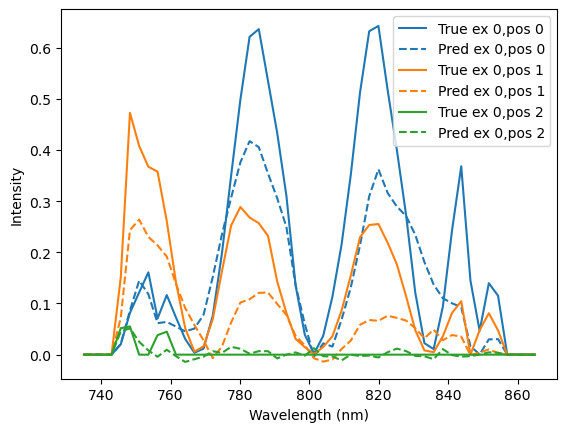

In [44]:
wls = np.linspace(desired_range[0],desired_range[1],50)

fig = plt.figure()
ax = fig.add_subplot(111)
j=0

coords = [coords1,coords2,coords3]

for i in range(3):
        line, = ax.plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
        ax.plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')


ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
plt.legend()

In [45]:
from scipy.ndimage import rotate
angle = 0.28395252967192336

jannik_oned_cube = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/signalfft_padded_1D_fixed_thresholded_new.npy')

cube_mean_pad = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/signalfft_mean_padded_rotated_fixed_thresholded_new.npy')
cube_zero_pad = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/signalfft_zero_padded_rotated_fixed_thresholded_new.npy')

# cube = hlp.load_cube('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_analysis_exptime_8000_us/', postfix = 'fixed_thresholded_new')
rotated_cube_mean = rotate(cube_mean_pad, angle, axes=(0,1))
oned_rotated_cube_mean = np.mean(rotated_cube_mean,axis=(0))

rotated_cube_zero = rotate(cube_zero_pad, angle, axes=(0,1))
oned_rotated_cube_zero = np.mean(rotated_cube_zero,axis=(0))

fig,ax = plt.subplots(1,3,dpi=100,figsize=(10,3))
# ax[0].plot(np.mean(cube,axis=(0,1)), 'r')
# ax[0].plot(np.mean(rotated_cube,axis=(0,1)), 'b')
ax[0].plot(np.mean(oned_rotated_cube_mean,axis=(0)),'g')
ax[1].plot(np.mean(oned_rotated_cube_zero,axis=(0)),'g')
ax[2].plot(np.mean(jannik_oned_cube,axis=0))

KeyboardInterrupt: 

In [6]:
oned_rotated_cube_zero.shape

(2450, 151)

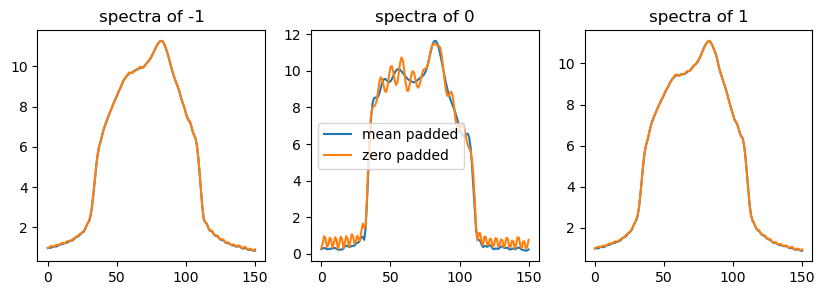

In [10]:
fig,ax = plt.subplots(1,3,dpi=100,figsize=(10,3))

ax[0].plot(np.mean(oned_rotated_cube_mean[:700],axis=(0)))
ax[0].plot(np.mean(oned_rotated_cube_zero[:700],axis=(0)))
ax[1].plot(np.mean(oned_rotated_cube_mean[700:1700],axis=(0)))
ax[1].plot(np.mean(oned_rotated_cube_zero[700:1700],axis=(0)))
ax[2].plot(np.mean(oned_rotated_cube_mean[1700:],axis=(0)))
ax[2].plot(np.mean(oned_rotated_cube_zero[1700:],axis=(0)))

ax[0].set_title('spectra of -1')
ax[1].set_title('spectra of 0')
ax[2].set_title('spectra of 1')

ax[1].legend(('mean padded','zero padded'))

### Check alignment

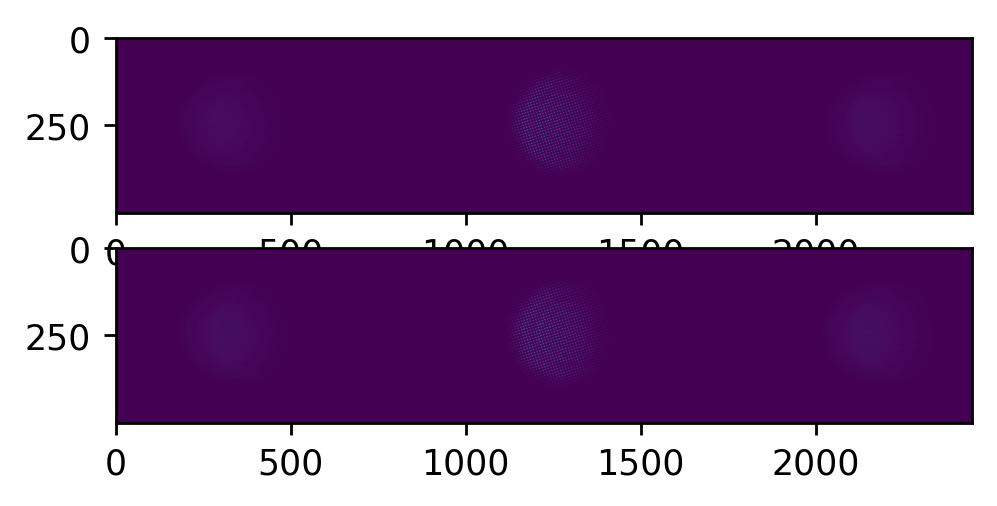

In [57]:
fig,ax = plt.subplots(2,1,dpi=250,figsize =(10,2))

ax[0].imshow(x[0].cpu())
ax[1].imshow(x_syn[0].cpu())

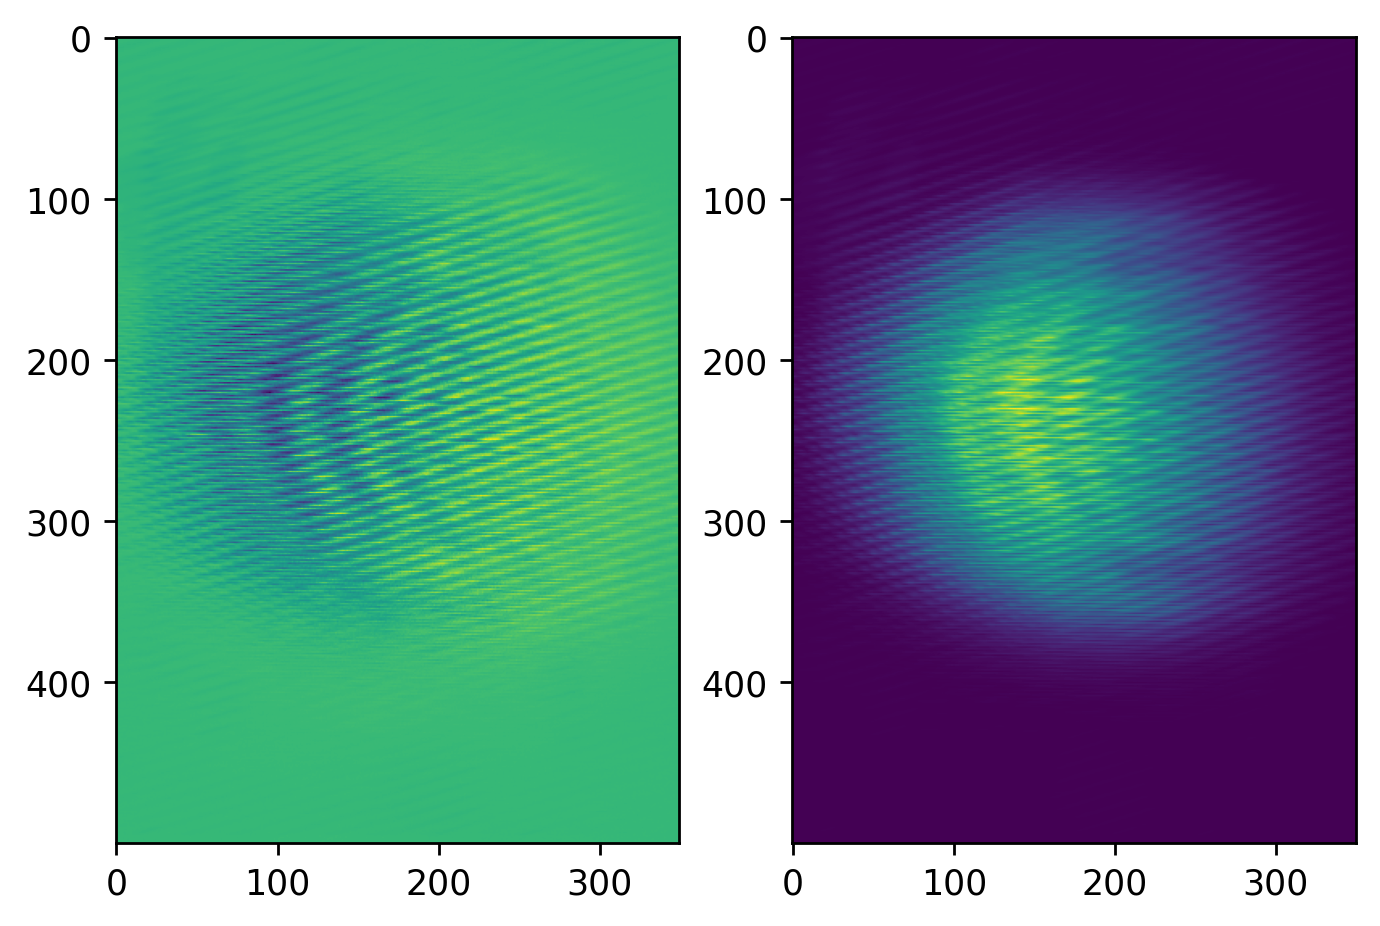

In [63]:
fig,ax = plt.subplots(1,2,dpi=250)

ax[0].imshow(x[0,:,150:500].cpu() - x_syn[0,:,150:500].cpu())
ax[1].imshow(x_syn[0,:,150:500].cpu())

In [87]:
_, spectras = hlp.create_bs_data(desired_channels=50,desired_range=desired_range, cube = undisp_cube, fts_dir = '20230906_1grating_mask_data_exptime_6250_us', cube_dir = '20230906_1grating_pinhole_analysis_exptime_8000_us',interp_type='average',device=device) #here we'll work with synthetic data. 

test = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_data_exptime_6250_us/spectra.npy')
test2 = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230804_1grating_mask_data_exptime_2400_us/spectra.npy')

collecting the undispersed cube and spectra.


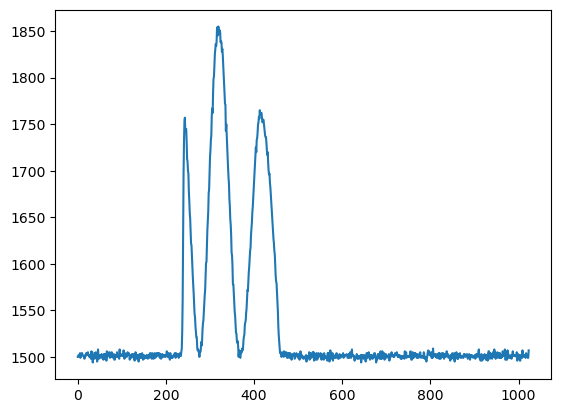

In [89]:
plt.plot(test2[:,600])

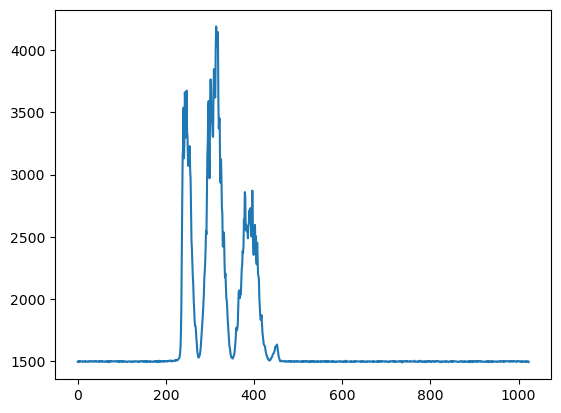

In [85]:
plt.plot(test[:,500])

In [79]:
test.shape

(1024, 1499)

In [ ]:
undisp_cube, spectras = hlp.create_bs_data(desired_channels=50,desired_range=desired_range, cube = undisp_cube, fts_dir = '20230906_1grating_mask_data_exptime_6250_us', cube_dir = '20230906_pinhole_analysis_exptime_200_us',interp_type='average',device=device) #here we'll work with synthetic data. 
_, spectras = hlp.create_bs_data(desired_channels=50,desired_range=desired_range, cube = undisp_cube, fts_dir = '20230906_1grating_mask_data_exptime_6250_us', cube_dir = '20230906_1grating_pinhole_analysis_exptime_8000_us',interp_type='average',device=device) #here we'll work with synthetic data. 

ftsdataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras,dir = '20230906_1grating_pinhole_data_exptime_8000_us',  crop=cropsize, random_shifts=False, angle = angle)

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras, crop=cropsize, random_shifts=False)
mask = torch.tensor(np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_mask_analysis_exptime_6250_us/mask.npy')).to(device)


batch_size = 2

cropsize = [500, 640]

spectras = spectras[:,500:950]



torch.Size([2, 50, 500, 2448])